<h1>LRP Analysis</h1>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Define the neural network architecture
class GaussianEstimatorNN(nn.Module):
    def __init__(self):
        super(GaussianEstimatorNN, self).__init__()
        self.input_layer = nn.Linear(2, 32)  # Input layer with 2 inputs (x, y)
        self.hidden_layer = nn.Linear(32, 32)  # Hidden layer with 32 units
        self.output_layer = nn.Linear(32, 1)  # Output layer with 1 output (PDF value)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.relu(self.input_layer(x))
        x = self.relu(self.hidden_layer(x))
        return self.output_layer(x)

# Function to generate training samples
def generate_samples(n_samples):
    x = torch.empty(n_samples, 2).uniform_(-5, 5)  # Uniform samples in [-5, 5] for x and y
    mean = torch.tensor([0.0, 0.0])
    cov = torch.tensor([[1.0, 0.0], [0.0, 1.0]])  # Corrected covariance matrix to be positive definite
    inv_cov = torch.inverse(cov)
    targets = torch.empty(n_samples, 1)

    for i in range(n_samples):
        diff = x[i] - mean
        exponent = -0.5 * torch.dot(diff, torch.mv(inv_cov, diff))
        pdf_value = (1 / (2 * math.pi * torch.det(cov).sqrt())) * torch.exp(exponent)
        targets[i] = pdf_value

    return x, targets

# Training parameters
n_samples = 1000
batch_size = 64
epochs = 50
learning_rate = 0.001

# Create the neural network, loss function, and optimizer
model = GaussianEstimatorNN().cuda() if torch.cuda.is_available() else GaussianEstimatorNN()
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()

    # Generate the dataset
    inputs, targets = generate_samples(n_samples)
    if torch.cuda.is_available():
        inputs, targets = inputs.cuda(), targets.cuda()

    # Split into batches
    for i in range(0, n_samples, batch_size):
        input_batch = inputs[i:i + batch_size]
        target_batch = targets[i:i + batch_size]

        # Forward pass
        output = model(input_batch)
        loss = criterion(output, target_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

print("Training complete!")

Epoch [10/50], Loss: 0.0002
Epoch [20/50], Loss: 0.0001
Epoch [30/50], Loss: 0.0000
Epoch [40/50], Loss: 0.0000
Epoch [50/50], Loss: 0.0000
Training complete!


<h2> Present an estimated Gaussian Distribution </h2>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


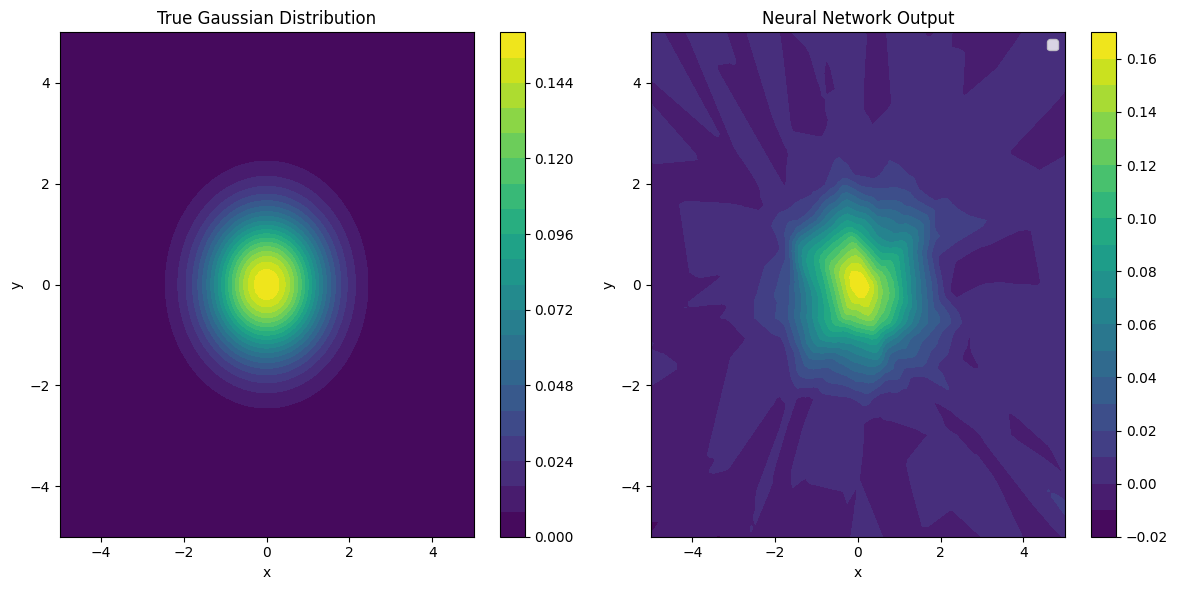

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [2]:
def gaussian_pdf(x, y, mean, cov):
    xy = np.stack([x, y], axis=-1)
    diff = xy - mean
    inv_cov = np.linalg.inv(cov)
    exponent = -0.5 * np.einsum('...i,ij,...j->...', diff, inv_cov, diff)
    pdf_value = (1 / (2 * np.pi * np.linalg.det(cov) ** 0.5)) * np.exp(exponent)
    return pdf_value
mean = np.array([0.0, 0.0])
cov = np.array([[1.0, 0.0], [0.0, 1.0]])

# Generate grid for the contour plot
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)

# Generate the true Gaussian distribution contour plot
Z = gaussian_pdf(X, Y, mean, cov)

plt.figure(figsize=(12, 6))

# Plot the true Gaussian distribution
plt.subplot(1, 2, 1)
plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar()
plt.title('True Gaussian Distribution')
plt.xlabel('x')
plt.ylabel('y')
model.eval()
X_flat = X.flatten()
Y_flat = Y.flatten()
grid_points = torch.tensor(np.stack([X_flat, Y_flat], axis=-1), dtype=torch.float32)

if torch.cuda.is_available():
    grid_points = grid_points.cuda()

with torch.no_grad():
    Z_nn = model(grid_points).cpu().numpy()

Z_nn = Z_nn.reshape(X.shape)

plt.subplot(1, 2, 2)
plt.contourf(X, Y, Z_nn, levels=20, cmap='viridis')
plt.colorbar()
plt.title('Neural Network Output')
plt.xlabel('x')
plt.ylabel('y')
# Plot a point of interest (POI) as a red dot

plt.legend()
plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()

XAI Methods not implemented

In [68]:
def get_gradient(model, point):
    """
    Computes the gradient of the model output with respect to the input point.
    
    Args:
        model: a PyTorch model
        point: a 1D torch tensor of shape (input_dim,) or (1, input_dim)

    Returns:
        gradient: a 1D torch tensor of shape (input_dim,)
    """
    point = torch.tensor(point, dtype=torch.float32)
    model.eval()
    point = point.clone().detach().requires_grad_(True)

    output = model(point)
    if output.ndim > 1:
        output = output.squeeze()

    # If scalar output
    assert output.numel() == 1, "Output must be scalar for gradient calculation"
    output.backward()

    gradient = point.grad.detach().clone()
    return gradient

def smooth_grad(model, input_tensor, n_samples=50, noise_std=2., multiply_by_input=False):
    """
    Computes SmoothGrad explanation by averaging noisy gradients.
    
    Args:
        model: PyTorch model (should be in eval mode)
        input_tensor: 1D torch.Tensor of shape [input_dim]
        n_samples: number of noisy samples to draw
        noise_std: standard deviation of Gaussian noise to add
        multiply_by_input: if True, returns gradient * input (Gradient × Input)

    Returns:
        smooth_grad: torch.Tensor of shape [input_dim]
    """
    model.eval()
    grads = []

    for _ in range(n_samples):
        # Add noise to input
        noisy_input = input_tensor.clone().detach() + torch.randn_like(input_tensor) * noise_std
        noisy_input.requires_grad_(True)

        # Forward and backward
        output = model(noisy_input.unsqueeze(0))  # batch dim
        
        output.backward()

        grad = noisy_input.grad.clone().detach()
        
        if multiply_by_input:
            grad = grad * noisy_input.detach()

        grads.append(grad)

    # Average all gradients
    return torch.stack(grads).mean(dim=0)

def grad_cam_ish(model, point):
    activations = {}
    gradients = {}
    def forward_hook(name):
        def hook(module, input, output):
            activations[name] = output.detach()
        return hook

    # Hook to capture gradients w.r.t. outputs
    def backward_hook(name):
        def hook(module, grad_input, grad_output):
            gradients[name] = grad_output[0].detach()
        return hook

    # Register hooks for each layer
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            module.register_forward_hook(forward_hook(name))
            module.register_backward_hook(backward_hook(name))

    # === Sample input ===
    input_point = torch.tensor(point, requires_grad=True, dtype=torch.float32)

    # Forward pass
    output = model(input_point)

    # Backward pass (ensure scalar output)
    output.backward()

    # Mean gradient for each neuron (shape: [32])
    weights = gradients['input_layer'].mean(dim=0)  # like alpha_k

    # Weighted sum of activations (shape: [1, 32])
    cam = (weights * activations['input_layer'].squeeze()).cpu().numpy()

    # Optional: ReLU to zero out negatives
    cam = np.maximum(cam, 0)

    input_contrib = cam @ model.input_layer.weight.detach().numpy()
    return input_contrib

def integrated_gradients(model, input_tensor, baseline=None, steps=50):
    """
    Compute Integrated Gradients for a single input.
    Args:
        model: PyTorch model
        input_tensor: 1D torch.Tensor, input point
        baseline: baseline input (same shape), default zero
        steps: number of interpolation steps

    Returns:
        IG attribution vector
    """
    model.eval()
    if baseline is None:
        baseline = torch.zeros_like(input_tensor)

    scaled_inputs = [
        baseline + (float(i) / steps) * (input_tensor - baseline)
        for i in range(1, steps + 1)
    ]

    grads = []
    for x in scaled_inputs:
        x = x.clone().detach().requires_grad_(True)
        output = model(x.unsqueeze(0))
        output.backward()
        grads.append(x.grad.detach())

    avg_grad = torch.stack(grads).mean(dim=0)
    ig = (input_tensor - baseline) * avg_grad
    return ig

In [71]:
from FeatureImportance.methods.FiniteDifferences import FiniteDifferences
from FeatureImportance.methods.LRP import TwoDWeights_LRPModel
from FeatureImportance.methods.LIME import LIME
from FeatureImportance.methods.SHAP import SHAP

lime = LIME(model, 1)
shap = SHAP(model)
fd = FiniteDifferences(model)
lrp = TwoDWeights_LRPModel(model)

def get_LRP(model, points):
    lrp_exp = []
    POEs_torch = torch.tensor(points, dtype = torch.float32)
    for i in POEs_torch:
        lrp = TwoDWeights_LRPModel(model)
        _, lrp_expt = lrp.get_FI(i)
        lrp_exp.append(lrp_expt[0].numpy())
    lrp_exp = np.stack(lrp_exp)
    return lrp_exp

def get_grad(model, points):
    POEs_torch = torch.tensor(points, dtype = torch.float32)
    grad_exp = []
    for i in POEs_torch:
        grad_exp.append(get_gradient(model, i).numpy())
    
    grad_exp = np.stack(grad_exp)
    return grad_exp

def get_SHAP(model, points):
    shap = SHAP(model)
    shap = shap.get_fi(points)[1]
    return shap

def get_LIME(model, points):
    lime = LIME(model, 1)
    lime = lime.get_fi(points)
    return lime[1][:,0]

def get_SmoothGrad(model, points):
    points = torch.tensor(points, dtype = torch.float32)
    exps = []
    for i in points:
        exp = smooth_grad(model, i)
        exps.append(exp.detach().numpy())
    return np.stack(exps)

def get_GradCam(model, points):
    points = torch.tensor(points, dtype = torch.float32)
    exps = []
    for i in points:
        exp = grad_cam_ish(model, i)
        exps.append(exp)
    return np.stack(exps)

def get_IntegratedGradients(model, points):
    points = torch.tensor(points, dtype = torch.float32)
    exps = []
    for i in points:
        exp = integrated_gradients(model, i)
        exps.append(exp.detach().numpy())
    return np.stack(exps)

In [72]:
POEs = np.array([[4.0, -4.0],[1.0,1.0],[0.0,0.0],[2.0,2.0],[-1.,-1],[1.,-1.],[-1.,1.],[3.,-3.2]])
print("FD: ", get_grad(model, POEs))
print("LRP: ", get_LRP(model, POEs))
print("SHAP: ", get_SHAP(model, POEs))
print("LIME: ", get_LIME(model, POEs))
print("smooth_grad: ", get_SmoothGrad(model, POEs))
print("grad_cam: ", get_GradCam(model, POEs))
print("integrated_grads: ", get_GradCam(model, POEs))

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


FD:  [[ 0.00873594  0.00828382]
 [ 0.01185424 -0.06255495]
 [ 0.02103711  0.01885983]
 [-0.00460208  0.00129949]
 [ 0.04565476  0.02572972]
 [-0.06501018  0.07875698]
 [ 0.05464405 -0.09452799]
 [ 0.01307432  0.00974501]]
LRP:  [[ 7.2116251e-05  8.7031128e-04]
 [ 4.8517399e-03  5.6441154e-02]
 [ 8.2636163e-02  8.2636163e-02]
 [ 1.5667897e-03  3.9947783e-03]
 [ 3.8895801e-02  2.9207472e-02]
 [ 4.6072520e-02  1.3206640e-02]
 [ 3.0464955e-02  3.5048295e-02]
 [-5.9514743e-04 -1.0216173e-03]]
SHAP:  [[-0.02572624 -0.02637485]
 [ 0.00268794  0.00556145]
 [ 0.05746893  0.05475988]
 [-0.0223166  -0.02516535]
 [ 0.00714295  0.0079168 ]
 [ 0.00196038  0.00427527]
 [ 0.00556863  0.0069011 ]
 [-0.02678598 -0.0278743 ]]
LIME:  [[ 0.00931614 -0.01092551]
 [ 0.03458313  0.00114061]
 [ 0.02507118 -0.01375958]
 [ 0.03304795  0.01336592]
 [ 0.00604528 -0.02803333]
 [ 0.0293658  -0.02205249]
 [ 0.00219584  0.00106762]
 [ 0.01859358 -0.01875054]]


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


smooth_grad:  [[ 2.9499337e-04 -1.5322566e-05]
 [-1.0316173e-02 -1.0566226e-02]
 [-6.8786321e-04  3.5256811e-03]
 [-2.1149118e-03 -9.0665231e-03]
 [ 6.3270954e-03  7.8169070e-03]
 [-7.6178266e-03  7.9502389e-03]
 [ 2.7360904e-03 -6.0032778e-03]
 [-1.1847087e-03  3.7803960e-03]]
grad_cam:  [[-0.00751255  0.00431664]
 [ 0.00596232  0.00623431]
 [-0.00151275  0.0002025 ]
 [ 0.00769226  0.00756099]
 [ 0.0051964   0.00299378]
 [ 0.00377281 -0.00453614]
 [-0.00178938  0.00116447]
 [-0.00455454  0.00277175]]
integrated_grads:  [[-0.00751255  0.00431664]
 [ 0.00596232  0.00623431]
 [-0.00151275  0.0002025 ]
 [ 0.00769226  0.00756099]
 [ 0.0051964   0.00299378]
 [ 0.00377281 -0.00453614]
 [-0.00178938  0.00116447]
 [-0.00455454  0.00277175]]


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [55]:
def cosine_sim_np(a, b, eps=1e-8):
    return a.dot(b)/(np.linalg.norm(a) * np.linalg.norm(b) + eps)

<h3> Gradient x LRP Cosine Similarity </h3>

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


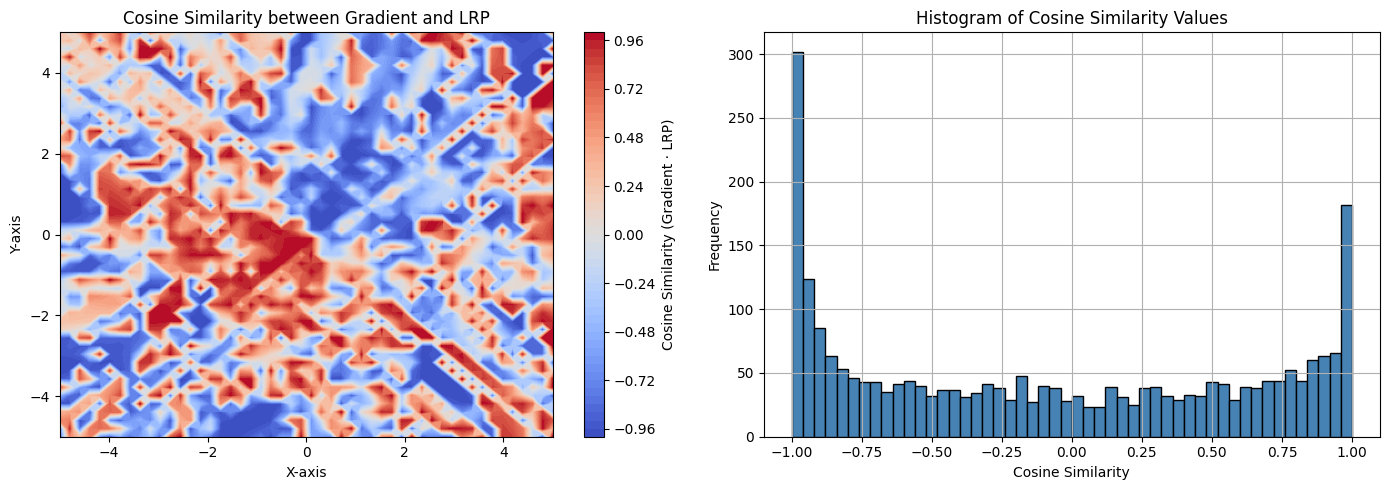

In [86]:
grid_size = 50
x_vals = np.linspace(-5, 5, grid_size)
y_vals = np.linspace(-5, 5, grid_size)
X, Y = np.meshgrid(x_vals, y_vals)

cosine_map = np.zeros_like(X)

model.eval()

for i in range(grid_size):
    for j in range(grid_size):
        point = np.array([[X[i, j], Y[i, j]]])
        grad = get_grad(model, point)[0]
        lrp_expt = get_LRP(model, point)[0]
        cos = cosine_sim_np(grad, lrp_expt).item()
        cosine_map[i, j] = cos

       

import matplotlib.pyplot as plt

# Create a 1-row, 2-column subplot layout
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot the cosine similarity contour map
contour = axs[0].contourf(X, Y, cosine_map, levels=50, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(contour, ax=axs[0], label='Cosine Similarity (Gradient · LRP)')
axs[0].set_title('Cosine Similarity between Gradient and LRP')
axs[0].set_xlabel('X-axis')
axs[0].set_ylabel('Y-axis')

# Plot the histogram of cosine similarity values
cosine_values = cosine_map.flatten()
axs[1].hist(cosine_values, bins=50, color='steelblue', edgecolor='black')
axs[1].set_title('Histogram of Cosine Similarity Values')
axs[1].set_xlabel('Cosine Similarity')
axs[1].set_ylabel('Frequency')
axs[1].grid(True)

plt.tight_layout()
plt.show()

<h3> Scaled Gradient x LRP cosine similarity </h3>

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


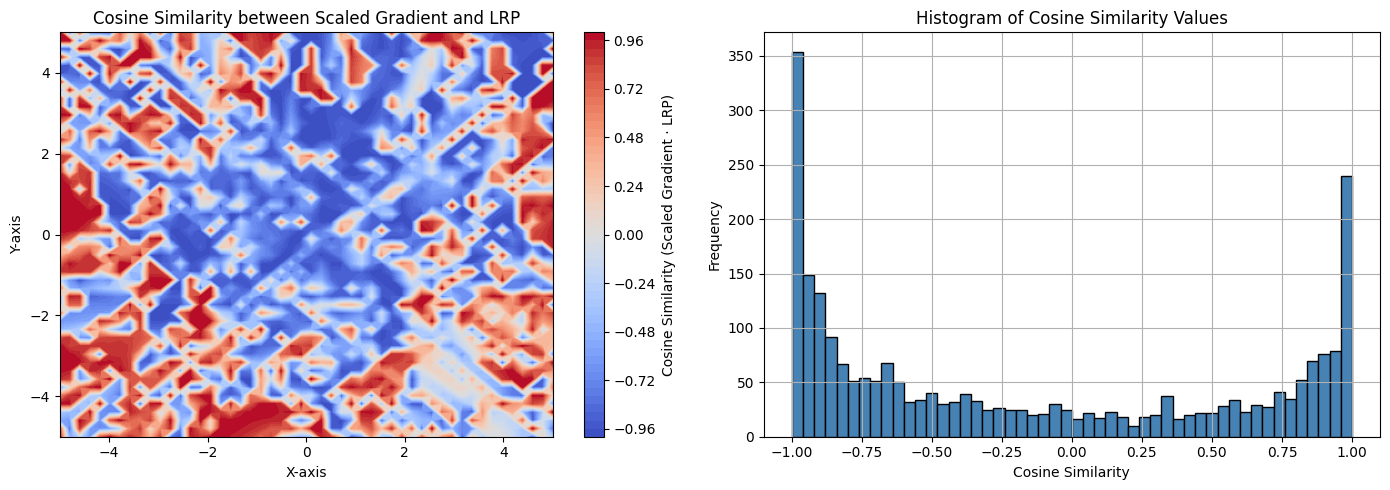

In [58]:
grid_size = 50
x_vals = np.linspace(-5, 5, grid_size)
y_vals = np.linspace(-5, 5, grid_size)
X, Y = np.meshgrid(x_vals, y_vals)

cosine_map = np.zeros_like(X)

model.eval()

for i in range(grid_size):
    for j in range(grid_size):
        point = np.array([[X[i, j], Y[i, j]]])
        grad = get_grad(model, point)[0] * point
        lrp_expt = get_LRP(model, point)[0]
        cos = cosine_sim_np(grad, lrp_expt).item()
        cosine_map[i, j] = cos

       

import matplotlib.pyplot as plt

# Create a 1-row, 2-column subplot layout
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot the cosine similarity contour map
contour = axs[0].contourf(X, Y, cosine_map, levels=50, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(contour, ax=axs[0], label='Cosine Similarity (Scaled Gradient · LRP)')
axs[0].set_title('Cosine Similarity between Scaled Gradient and LRP')
axs[0].set_xlabel('X-axis')
axs[0].set_ylabel('Y-axis')

# Plot the histogram of cosine similarity values
cosine_values = cosine_map.flatten()
axs[1].hist(cosine_values, bins=50, color='steelblue', edgecolor='black')
axs[1].set_title('Histogram of Cosine Similarity Values')
axs[1].set_xlabel('Cosine Similarity')
axs[1].set_ylabel('Frequency')
axs[1].grid(True)

plt.tight_layout()
plt.show()


<h3> 

<h3> SmoothGrad x LRP Cosine Check </h3>

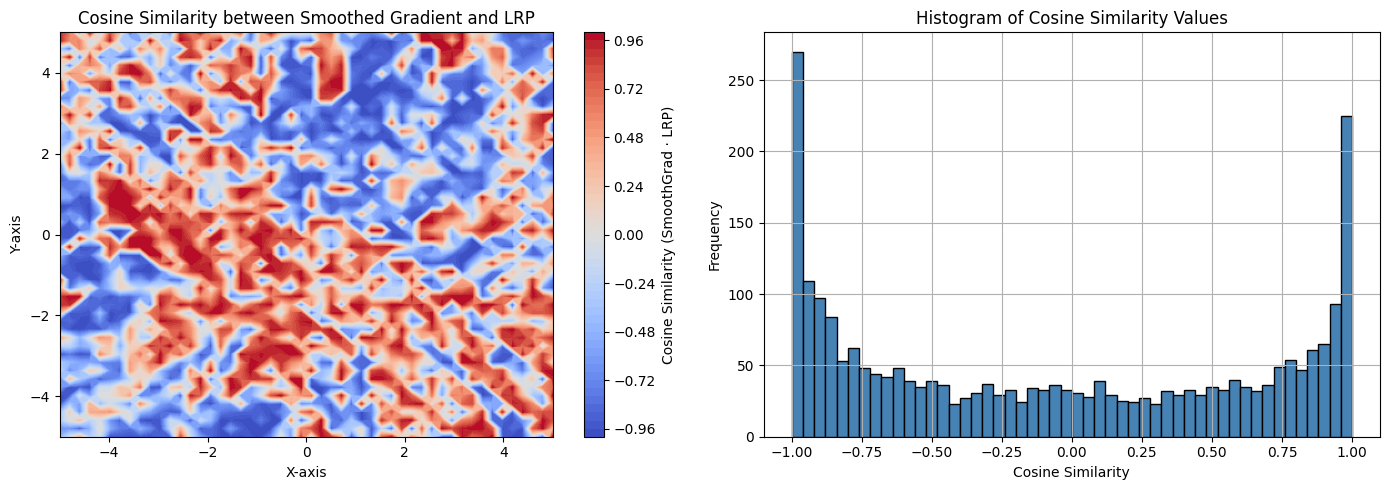

In [74]:
grid_size = 50
x_vals = np.linspace(-5, 5, grid_size)
y_vals = np.linspace(-5, 5, grid_size)
X, Y = np.meshgrid(x_vals, y_vals)

cosine_map = np.zeros_like(X)

model.eval()

for i in range(grid_size):
    for j in range(grid_size):
        point = np.array([[X[i, j], Y[i, j]]])
        grad = get_SmoothGrad(model, point)[0]
        lrp_expt = get_LRP(model, point)[0]
        cos = cosine_sim_np(grad, lrp_expt).item()
        cosine_map[i, j] = cos

       

import matplotlib.pyplot as plt

# Create a 1-row, 2-column subplot layout
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot the cosine similarity contour map
contour = axs[0].contourf(X, Y, cosine_map, levels=50, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(contour, ax=axs[0], label='Cosine Similarity (SmoothGrad · LRP)')
axs[0].set_title('Cosine Similarity between Smoothed Gradient and LRP')
axs[0].set_xlabel('X-axis')
axs[0].set_ylabel('Y-axis')

# Plot the histogram of cosine similarity values
cosine_values = cosine_map.flatten()
axs[1].hist(cosine_values, bins=50, color='steelblue', edgecolor='black')
axs[1].set_title('Histogram of Cosine Similarity Values')
axs[1].set_xlabel('Cosine Similarity')
axs[1].set_ylabel('Frequency')
axs[1].grid(True)

plt.tight_layout()
plt.show()


<h1> What are explanation methods doing? </h1>

In [96]:

import numpy as np

def uniform_circle_vectors(center: np.ndarray, radius: float, n: int):
    """
    Generates `n` evenly spaced points on the circumference of a circle in 2D.

    Args:
        center (np.ndarray): Shape (2,), the center of the circle.
        radius (float): Distance from the center.
        n (int): Number of vectors to generate.

    Returns:
        np.ndarray: Shape (n, 2), points at fixed radius from center.
    """
    assert center.shape == (2,), "This function is 2D only. Center must be shape (2,)."
    
    angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
    x = center[0] + radius * np.cos(angles)
    y = center[1] + radius * np.sin(angles)

    return np.stack([x, y], axis=1)

def evaluate_region(model, center: np.ndarray, radius: float = 0.005, n: int = 50):
    """
    Samples points in a circle around `center`, evaluates the model,
    and returns the vectors of greatest and least change from `center`.

    Args:
        model (torch.nn.Module): The PyTorch model.
        center (np.ndarray): The center point (shape: (2,)).
        radius (float): Radius for sampling.
        n (int): Number of samples.

    Returns:
        max_delta (np.ndarray): Direction of greatest model output change (from center).
        min_delta (np.ndarray): Direction of least model output change (from center).
    """
    assert center.shape == (2,), "This implementation assumes 2D input vectors."

    # Generate points on the circle
    points = uniform_circle_vectors(center, radius, n)
    
    # Convert center to tensor and evaluate base output
    center_tensor = torch.tensor(center, dtype=torch.float32).unsqueeze(0)
    model.eval()
    with torch.no_grad():
        base_output = model(center_tensor).flatten()
    
    max_change = -float('inf')
    min_change = float('inf')
    max_delta = None
    min_delta = None

    for point in points:
        point_tensor = torch.tensor(point, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            output = model(point_tensor).flatten()
        delta_output = torch.norm(output - base_output).item()
        delta_vec = point - center  # direction vector

        if delta_output > max_change:
            max_change = delta_output
            max_delta = delta_vec

        if delta_output < min_change:
            min_change = delta_output
            min_delta = delta_vec

    return max_delta, min_delta


In [139]:
def plot_nn_output_with_deltas(model, center, max_delta, min_delta, X, Y, get_grad, grad_scale=1.0):
    model.eval()

    # Prepare grid input
    X_flat = X.flatten()
    Y_flat = Y.flatten()
    grid_points = torch.tensor(np.stack([X_flat, Y_flat], axis=-1), dtype=torch.float32)

    if torch.cuda.is_available():
        model = model.cuda()
        grid_points = grid_points.cuda()

    with torch.no_grad():
        Z_nn = model(grid_points).cpu().numpy()

    Z_nn = Z_nn.reshape(X.shape)

    # Plot contour
    plt.figure(figsize=(7, 6))
    plt.contourf(X, Y, Z_nn, levels=20, cmap='viridis')
    plt.colorbar(label='NN Output')
    plt.title('NN Output with Max/Min Change and Gradient Vector')
    plt.xlabel('x')
    plt.ylabel('y')

    # Plot center
    plt.plot(center[0], center[1], 'ro', label='Center')

    # Use quiver for arrows
    def draw_quiver(delta, color, label):
        plt.quiver(center[0], center[1], delta[0]*50000, delta[1]*50000,
                   angles='xy', scale_units='xy', scale=1,
                   color=color, label=label, width=0.005)

    draw_quiver(max_delta, 'black', 'Max Change')
    draw_quiver(min_delta, 'white', 'Min Change')

    # Add gradient vector
    grad = get_grad(model, center.reshape(1, -1))[0]
    grad_vec = grad
    draw_quiver(grad_vec, 'red', 'Gradient')

    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


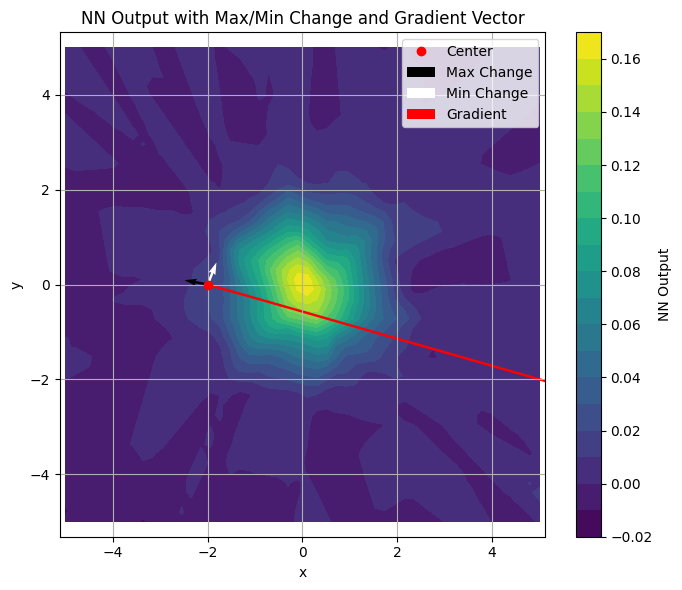

In [152]:
center = np.array([-2.0, 0.0])
max_delta, min_delta = evaluate_region(model, center, radius = 1e-5, n=5000)
plot_nn_output_with_deltas(model, center, max_delta, min_delta, X, Y, get_grad)

In [193]:
def uniform_circle_vectors(center: np.ndarray, radius: float, n: int):
    angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
    x = center[0] + radius * np.cos(angles)
    y = center[1] + radius * np.sin(angles)
    return np.stack([x, y], axis=1)

def get_max_change(model, point, radius=1e-5, n=500):
    """
    Samples points in a circle around `center`, evaluates the model,
    and returns the vectors of greatest and least change from `center`.

    Args:
        model (torch.nn.Module): The PyTorch model.
        center (np.ndarray): The center point (shape: (2,)).
        radius (float): Radius for sampling.
        n (int): Number of samples.

    Returns:
        max_delta (np.ndarray): Direction of greatest model output change (from center).
        min_delta (np.ndarray): Direction of least model output change (from center).
    """
    center = point[0]
    assert center.shape == (2,), "This implementation assumes 2D input vectors."

    # Generate points on the circle
    points = uniform_circle_vectors(center, radius, n)
    
    # Convert center to tensor and evaluate base output
    center_tensor = torch.tensor(center, dtype=torch.float32).unsqueeze(0)
    model.eval()
    with torch.no_grad():
        base_output = model(center_tensor).flatten()
    
    max_change = -float('inf')
    min_change = float('inf')
    max_delta = None
    min_delta = None
    
    for point in points:
        point_tensor = torch.tensor(point, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            output = model(point_tensor).flatten()
        delta_output = output.item() - base_output.item()
        delta_vec = point - center  # direction vector
        
        if delta_output > max_change:
            max_change = delta_output
            max_delta = delta_vec
        if delta_output < min_change:
            min_change = delta_output
            min_delta = delta_vec

    return [max_delta * 10000]


def get_min_change(model, point, radius=1e-5, n=500):
    """
    Samples points in a circle around `center`, evaluates the model,
    and returns the vectors of greatest and least change from `center`.

    Args:
        model (torch.nn.Module): The PyTorch model.
        center (np.ndarray): The center point (shape: (2,)).
        radius (float): Radius for sampling.
        n (int): Number of samples.

    Returns:
        max_delta (np.ndarray): Direction of greatest model output change (from center).
        min_delta (np.ndarray): Direction of least model output change (from center).
    """
    center = point[0]
    assert center.shape == (2,), "This implementation assumes 2D input vectors."

    # Generate points on the circle
    points = uniform_circle_vectors(center, radius, n)
    
    # Convert center to tensor and evaluate base output
    center_tensor = torch.tensor(center, dtype=torch.float32).unsqueeze(0)
    model.eval()
    with torch.no_grad():
        base_output = model(center_tensor).flatten()
    
    max_change = -float('inf')
    min_change = float('inf')
    max_delta = None
    min_delta = None

    for point in points:
        point_tensor = torch.tensor(point, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            output = model(point_tensor).flatten()
        delta_output = output.item() - base_output.item()
        delta_vec = point - center  # direction vector

        if delta_output > max_change:
            max_change = delta_output
            max_delta = delta_vec

        if delta_output < min_change:
            min_change = delta_output
            min_delta = delta_vec

    return [min_delta * 10000]

def plot_vector_similarity_map(model, get_vec, get_LRP, label, grid_size=50):
    """
    Plots a heatmap and histogram of cosine similarity between LRP and a given vector-producing function.
    
    Args:
        model: PyTorch model
        get_vec: function(model, point) -> vector (e.g., gradient, max_change, min_change)
        get_LRP: function(model, point) -> vector
        label: string label for the type of vector
        grid_size: resolution of the mesh
    """
    x_vals = np.linspace(-5, 5, grid_size)
    y_vals = np.linspace(-5, 5, grid_size)
    X, Y = np.meshgrid(x_vals, y_vals)
    cosine_map = np.zeros_like(X)

    model.eval()
    for i in range(grid_size):
        for j in range(grid_size):
            point = np.array([[X[i, j], Y[i, j]]])
            vec = get_vec(model, point)[0]
            lrp = get_LRP(model, point)[0]
            cosine = cosine_sim_np(vec, lrp).item()
            cosine_map[i, j] = cosine

    # Heatmap
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    contour = axs[0].contourf(X, Y, cosine_map, levels=50, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(contour, ax=axs[0])
    axs[0].set_title(f'Cosine Similarity Heatmap: {label} vs LRP')
    axs[0].set_xlabel('X')
    axs[0].set_ylabel('Y')

    # Histogram
    cosine_values = cosine_map.flatten()
    axs[1].hist(cosine_values, bins=50, color='steelblue', edgecolor='black')
    axs[1].set_title(f'Histogram: {label} vs LRP')
    axs[1].set_xlabel('Cosine Similarity')
    axs[1].set_ylabel('Frequency')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


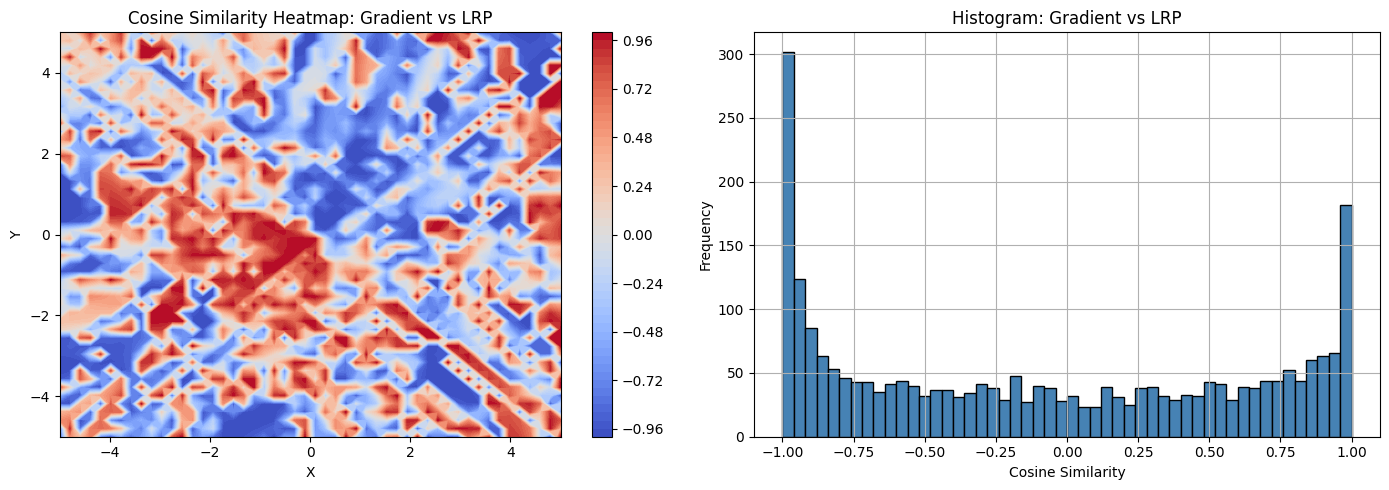

MemoryError: 

In [194]:
plot_vector_similarity_map(model, get_grad, get_LRP, label='Gradient')
plot_vector_similarity_map(model, get_max_change, get_LRP, label='Max Change')
plot_vector_similarity_map(model, get_min_change, get_LRP, label='Min Change')

In [183]:
plot_vector_similarity_map(model, get_grad, get_LRP, label='Gradient')
plot_vector_similarity_map(model, get_max_change, get_LRP, label='Max Change')
plot_vector_similarity_map(model, get_min_change, get_LRP, label='Min Change')

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


[ 0.03635685 -0.03334938]
[-0.00017577  0.0051053 ]
[-0.00017577  0.0051053 ]
[-0.00017577  0.0051053 ]
[-0.00017577  0.0051053 ]
[0.00282235 0.00533514]
[-0.01293201  0.01215317]
[-0.01293201  0.01215317]
[-0.01293201  0.01215317]
[ 0.01345947 -0.00137685]
[ 0.01345947 -0.00137685]
[ 0.02566034 -0.0033761 ]
[-0.01793157  0.0138325 ]
[-0.02135465  0.01705524]
[-0.02135465  0.01705524]
[0.00532856 0.00541858]
[0.00123438 0.00633848]
[0.00123438 0.00633848]
[0.00123438 0.00633848]
[0.00123438 0.00633848]
[0.00123438 0.00633848]
[0.01175447 0.00170727]
[0.01175447 0.00170727]
[ 0.02529423 -0.00432525]
[ 0.02529423 -0.00432525]
[-0.01218706 -0.00599959]
[-0.01218706 -0.00599959]
[-0.01218706 -0.00599959]
[-0.01218706 -0.00599959]
[-0.01870616 -0.0054546 ]
[0.01429937 0.00750281]
[0.01880309 0.00870722]
[-0.0006131   0.00634105]
[-0.0006131   0.00634105]
[-0.00311458  0.00504349]
[-0.00311458  0.00504349]
[0.00373855 0.00489423]
[0.00373855 0.00489423]
[0.00373855 0.00489423]
[0.00373855 0.

KeyboardInterrupt: 

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


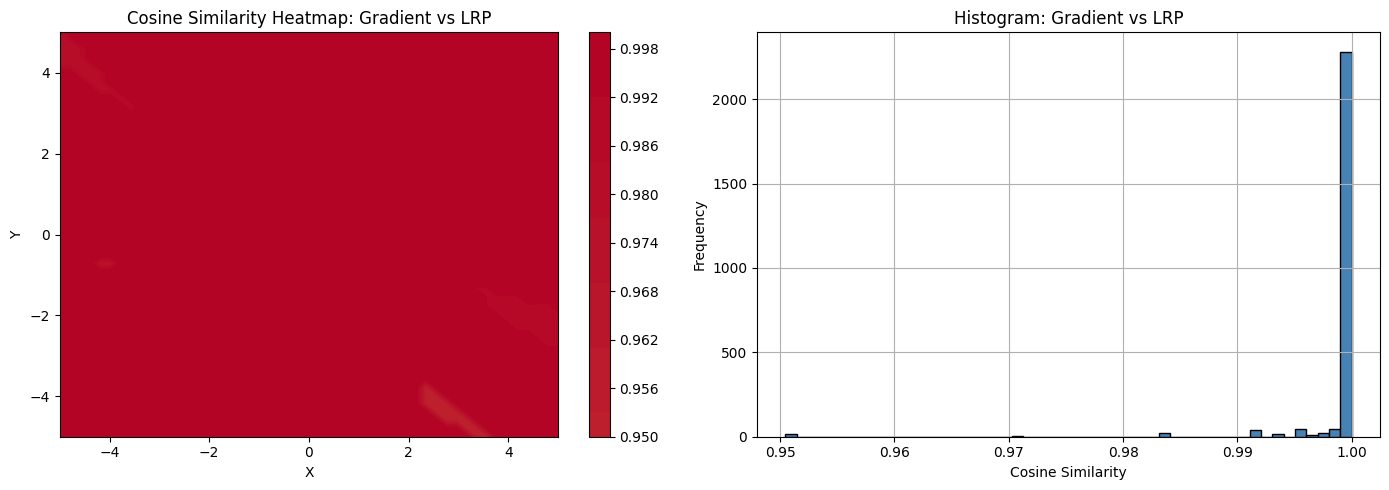

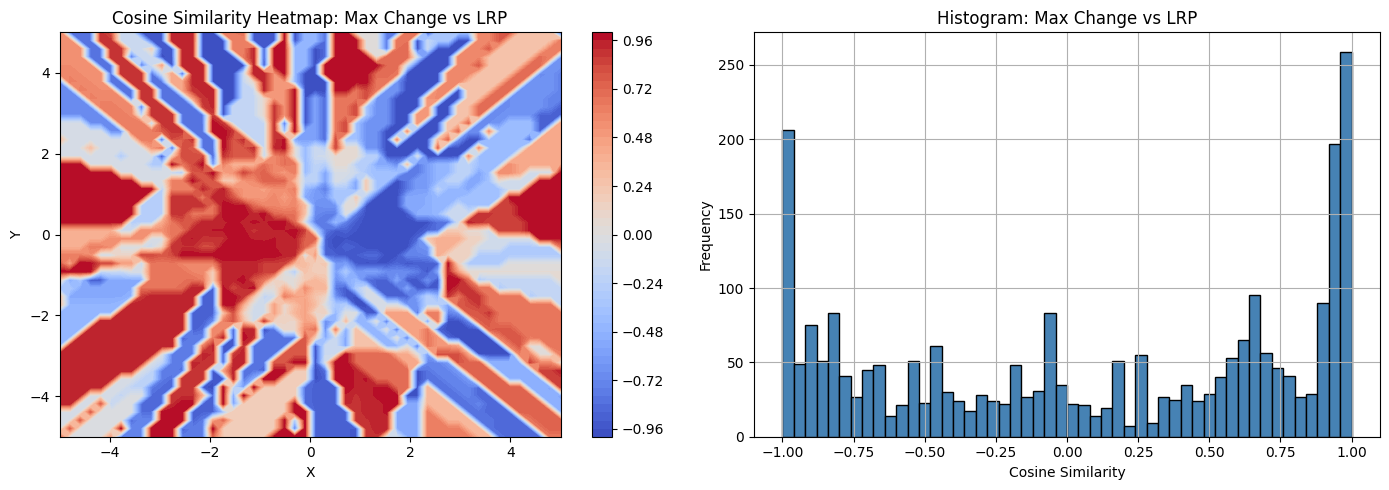

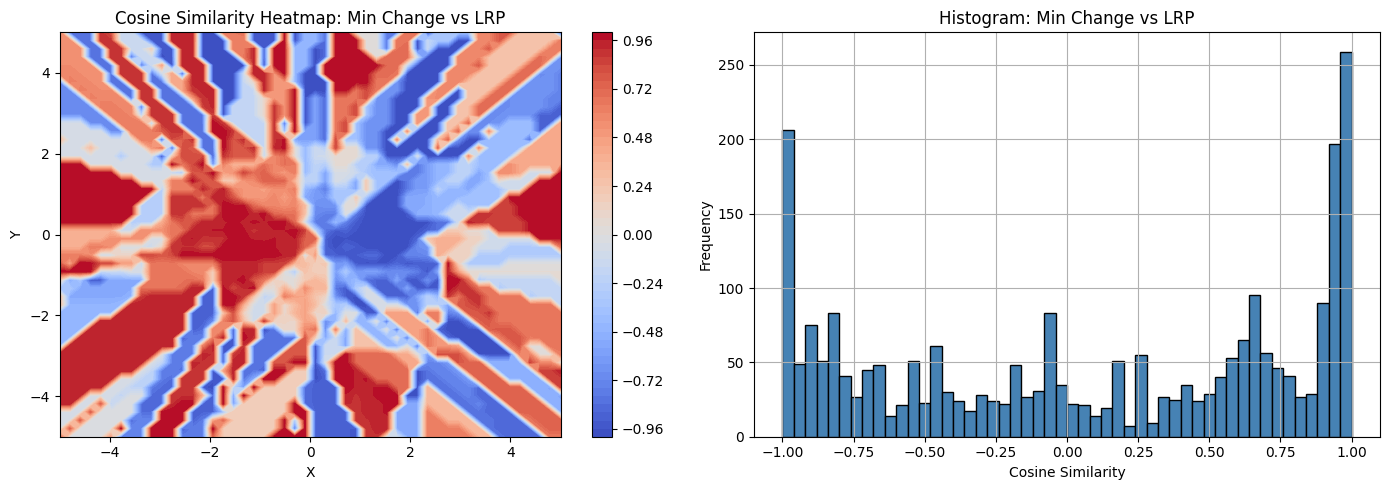

In [159]:
plot_vector_similarity_map(model, get_grad, get_grad, label='Gradient')
plot_vector_similarity_map(model, get_max_change, get_grad, label='Max Change')
plot_vector_similarity_map(model, get_min_change, get_grad, label='Min Change')

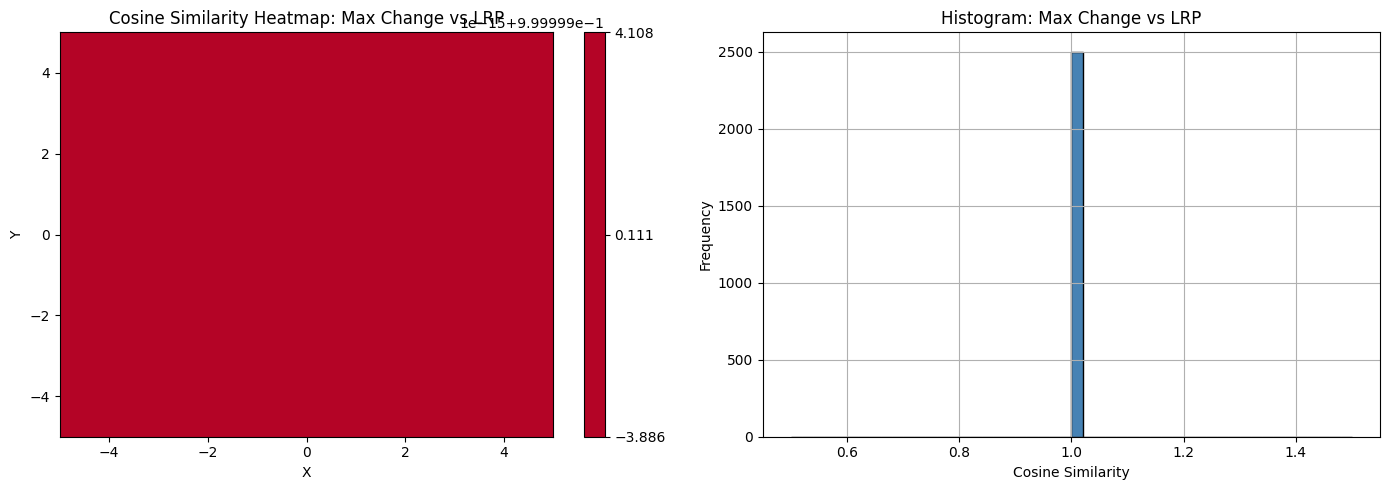

In [160]:
plot_vector_similarity_map(model, get_max_change, get_min_change, label='Max Change')

In [ ]:
def uniform_circle_vectors(center: np.ndarray, radius: float, n: int):
    angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
    x = center[0] + radius * np.cos(angles)
    y = center[1] + radius * np.sin(angles)
    return np.stack([x, y], axis=1)*center

def get_max_change(model, point, radius=0.005, n=16):
    """
    Returns the vector from `point` to the location of maximum **signed** change in output.
    """
    assert point.shape == (1, 2)
    center = point[0]
    samples = uniform_circle_vectors(center, radius, n)

    center_tensor = torch.tensor(center, dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        base_output = model(center_tensor).flatten().item()

    max_delta = None
    max_change = -float('inf')

    for sample in samples:
        sample_tensor = torch.tensor(sample, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            output = model(sample_tensor).flatten().item()
        signed_change = output - base_output
        if signed_change > max_change:
            max_change = signed_change
            max_delta = sample - center

    return np.array([max_delta])*center


def get_min_change(model, point, radius=0.005, n=16):
    """
    Returns the vector from `point` to the location of minimum **signed** change in output.
    """
    assert point.shape == (1, 2)
    center = point[0]
    samples = uniform_circle_vectors(center, radius, n)

    center_tensor = torch.tensor(center, dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        base_output = model(center_tensor).flatten().item()

    min_delta = None
    min_change = float('inf')

    for sample in samples:
        sample_tensor = torch.tensor(sample, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            output = model(sample_tensor).flatten().item()
        signed_change = output - base_output
        if signed_change < min_change:
            min_change = signed_change
            min_delta = sample - center

    return np.array([min_delta])

def plot_vector_similarity_map(model, get_vec, get_LRP, label, grid_size=50):
    """
    Plots a heatmap and histogram of cosine similarity between LRP and a given vector-producing function.
    
    Args:
        model: PyTorch model
        get_vec: function(model, point) -> vector (e.g., gradient, max_change, min_change)
        get_LRP: function(model, point) -> vector
        label: string label for the type of vector
        grid_size: resolution of the mesh
    """
    x_vals = np.linspace(-5, 5, grid_size)
    y_vals = np.linspace(-5, 5, grid_size)
    X, Y = np.meshgrid(x_vals, y_vals)
    cosine_map = np.zeros_like(X)

    model.eval()
    for i in range(grid_size):
        for j in range(grid_size):
            point = np.array([[X[i, j], Y[i, j]]])
            vec = get_vec(model, point)[0]
            lrp = get_LRP(model, point)[0]
            cosine = cosine_sim_np(vec, lrp).item()
            cosine_map[i, j] = cosine

    # Heatmap
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    contour = axs[0].contourf(X, Y, cosine_map, levels=50, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(contour, ax=axs[0])
    axs[0].set_title(f'Cosine Similarity Heatmap: {label} vs LRP')
    axs[0].set_xlabel('X')
    axs[0].set_ylabel('Y')

    # Histogram
    cosine_values = cosine_map.flatten()
    axs[1].hist(cosine_values, bins=50, color='steelblue', edgecolor='black')
    axs[1].set_title(f'Histogram: {label} vs LRP')
    axs[1].set_xlabel('Cosine Similarity')
    axs[1].set_ylabel('Frequency')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
plot_vector_similarity_map(model, get_grad, get_LRP, label='Gradient')
plot_vector_similarity_map(model, get_max_change, get_LRP, label='Max Change')
plot_vector_similarity_map(model, get_min_change, get_LRP, label='Min Change')